In [ ]:
%reset

In [ ]:
pip install pyts matplotlib 

In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support as score

import matplotlib.pyplot as plt

import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM
from tensorflow.keras.models import Model

from scipy.signal import savgol_filter

import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback

import random
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2021-11-06 16:09:40.275755: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2021-11-06 16:09:41.635623: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-11-06 16:09:41.713667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-06 16:09:41.713733: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-11-06 16:09:41.728239: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-06 16:09:41.728326: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2021-11-06 16:09:41.735188: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [4]:
#M - months A - appliances N - num of imgs 

#file_name ="UKDALE_GAF_1h_18M9A1000N"
#file_name= "UKDALE_GAF_1h_12M10A300N"
#file_name = "UKDALE_GAF_1h_12M10A500N"
#file_name = "UK-DALE_GADF_60m_300S0X_9A5000N_NmB" # x is n of paralel imgs


#file_name = "test_REFIT+ECO+UKDALE+IAWE_GASF_13m100S10X"
file_name = "ALL_13m_100S5X-AVG-Y"

dir_path =os.path.abspath(os.getcwd())

#check if we are in cloud or in PC<

try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS_UNZIPPED/"f"{file_name}"
    #path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS/old2/"
except:
    print("reading from HDD")
    path = dir_path+"/data"

#check if file exists
try:
    file = h5py.File(f"{path}""/"f"{file_name}""/"f"{file_name}"".hdf5","r+")
    print("file exists, reading it...")
except:
    print("error reading the file!")


# function to make reading easier
def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.
    """
    images = []

    # Open the HDF5 file
    file = h5py.File(f"{path}""/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

reading from HDD
file exists, reading it...


In [5]:
def plot_confusion_matrix_norm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    

    plt.title(title)



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.colorbar()

In [6]:
def LSTM_3D(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
 
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [7]:
def LSTM_3D_32(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [8]:
def LSTM_3D_32_7and3(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [9]:
def LSTM_3D_extra_LSTM(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [10]:
def LSTM_3D_32_LSTM(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [11]:
def LSTM_3D_32_LSTM_dropout(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=True, unroll=False, dropout=0.6)(out)  # dropout=0.6
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [12]:
def LSTM_3D_32_LSTM_32(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [13]:
def LSTM_3D_V42(X_train, num_classes, lr = 0.0001):
    #derived from LSTM_3D_32_LSTM_32
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [14]:
def LSTM_3D_V43(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [15]:
def LSTM_3D_V44(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [16]:
def LSTM_3D_V45(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [17]:
def LSTM_3D_V46(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(8, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(8, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [18]:
def LSTM_3D_V47(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(8, return_sequences=True, unroll=False, dropout=0.1)(out)  # dropout=0.6
    out = LSTM(8, return_sequences=False, unroll=False, dropout=0.1)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [19]:
def LSTM_3D_32_7_LSTM_32_drop1(X_train, num_classes, lr = 0.0001):
    #V3x
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.60)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.6)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [20]:
def LSTM_3D_32_7_LSTM_32_drop2(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.20)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.6)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.6)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [21]:
def LSTM_3D_32_7_LSTM_32_drop3(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.60)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.6)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.6)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [22]:
def LSTM_3D_V51(X_train, num_classes, lr = 0.0001):
    #joined v44 and v42
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [23]:
def LSTM_3D_V52(X_train, num_classes, lr = 0.0001):
    #added droptouts more filters at the begining
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
        
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [24]:
def LSTM_3D_V53(X_train, num_classes, lr = 0.0001):
    #added droptouts (larger sizes)
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.30)(x)
        
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.30)(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.30)(x)

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [25]:
def LSTM_3D_V54(X_train, num_classes, lr = 0.0001):
    #added droptouts (larger sizes)
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
        
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [26]:
def LSTM_3D_V55(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)
        
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(x)
    
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [27]:
def LSTM_3D_V56(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [28]:
def LSTM_3D_V57(X_train, num_classes, lr = 0.0001):
    #joined v44 and v42
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [29]:
def LSTM_3D_V58(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(8, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(8, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [30]:
def LSTM_3D_V61(X_train, num_classes, lr = 0.0001):
    #FROM V56, REMOVED DROPOUT
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [31]:
def LSTM_3D_V62(X_train, num_classes, lr = 0.0001):
    #FROM V56, REMOVED ALL DROPOUTS
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [32]:
def LSTM_3D_V63(X_train, num_classes, lr = 0.0001):
    #FROM V56, ONE MORE CONV LAYER
    input_a = Input(shape = X_train.shape[1: ])
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [33]:
def LSTM_3D_V64(X_train, num_classes, lr = 0.0001):
    # REMOVED DROPOUT copy of V63
    input_a = Input(shape = X_train.shape[1: ])
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [34]:
def LSTM_Dense2(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(8, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(8, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    #out = Dense(16, activation = 'relu')(out)
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [35]:
def basic_cnn_functional(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(input_a)
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.10)(x)
    
    
    
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = Flatten()(out)
    # dense layer with 50 neurons
    dense = Dense(64, activation = 'relu')(out)
    # final layer with 10 neurons to classify the instances
    output = Dense(num_classes, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(lr = lr)
    model = keras.models.Model(inputs=input_a, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [36]:
#appliance_set = set()
appliance_instances = {}
all_appliances = []
datasets = ["ukdale"]
appliances_len = {}

for dataset in datasets:
      
    for appliance in file[dataset].keys():

        for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
            all_appliances.append(appliance)
            #appliance_set.add(appliance)
            
            samples = file[f"{dataset}""/"f"{appliance}""/"f"{building}""/gaf"].shape[0]
            
            if appliance in appliances_len:
                appliances_len[appliance].append(samples)#appliances_len[appliance] = appliances_len[appliance]+samples
            else:
                appliances_len[appliance] = [samples]
             
#available_appliances = list(appliance_set)
available_appliances_arr, instances = np.unique(all_appliances,return_counts=True)
available_appliances = list(available_appliances_arr)
for i,appliance in enumerate(available_appliances):
    appliance_instances[appliance] = instances[i]
    
print("available",available_appliances)
print("lengts",appliances_len)
print("instances",appliance_instances)

available ['HTPC', 'boiler', 'computer monitor', 'desktop computer', 'dish washer', 'freezer', 'fridge', 'fridge freezer', 'kettle', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'toaster', 'washer dryer', 'washing machine']
lengts {'HTPC': [3000], 'boiler': [2988, 589], 'computer monitor': [2388, 1329, 456], 'desktop computer': [346, 3000], 'dish washer': [680, 45, 53], 'freezer': [1690], 'fridge': [1705], 'fridge freezer': [3000, 1101], 'kettle': [5000, 647, 53, 627, 175], 'laptop computer': [3000, 1780, 126], 'light': [3000], 'microwave': [4819, 359, 52], 'server computer': [1986], 'television': [2770, 2264, 170], 'toaster': [3200, 58, 33], 'washer dryer': [1214, 1555], 'washing machine': [18, 67]}
instances {'HTPC': 1, 'boiler': 2, 'computer monitor': 3, 'desktop computer': 2, 'dish washer': 3, 'freezer': 1, 'fridge': 1, 'fridge freezer': 2, 'kettle': 5, 'laptop computer': 3, 'light': 1, 'microwave': 3, 'server computer': 1, 'television': 3, 'toaster': 3

In [33]:
sum_all = 0 
N = 2000
for e in appliances_len:
    print(e,appliances_len[e],sum(appliances_len[e]))
    sum_all += sum(appliances_len[e])
print("num of samples: ",sum_all)

appliance [990] 990
audio system [876, 1, 49, 770, 15] 1711
breadmaker [318] 318
broadband router [2254] 2254
computer [556, 121, 3, 352, 3524, 2059, 5000, 429, 3714, 4959, 5000] 25717
dehumidifier [613] 613
dish washer [18, 470, 35, 50, 15, 28, 110, 76, 466, 297, 402, 661, 96, 598, 594] 3916
electric space heater [646, 218, 70] 934
fan [25] 25
food processor [872, 5] 877
fridge [41, 136, 557, 2863, 1136, 1603, 209] 6545
fridge freezer [2167, 775, 1411, 1935, 5000, 2701, 5000, 4793, 1286, 1179, 3151, 3187, 5000, 5000] 42585
games console [178] 178
kettle [1793, 14, 855, 2364, 1818, 1389, 2035, 2597, 1522, 2848, 2875, 1176, 2248, 2272] 25806
microwave [632, 326, 338, 417, 239, 682, 225, 625, 773, 913, 623, 1318, 1684, 1371, 1069, 260] 11495
pond pump [3982] 3982
television [1183, 5000, 232, 1927, 1735, 4594, 5000, 1503, 953, 466, 923, 2325, 2576, 1487, 5000, 1805, 1214, 1614] 39537
toaster [298, 78, 518, 338, 453, 1000, 505, 715, 499] 4404
tumble dryer [53, 13, 79, 105, 184, 18, 888, 16

In [18]:
#refit
available_appliances.remove("fridge freezer")
available_appliances.remove("fan")
available_appliances.remove("toaster")


In [36]:
#for refit

HEKA = ["toaster","kettle"]
FF = ["fridge","fridge freezer"]
grouped_appliances = {
    
    "HEKA":HEKA,
    "fridge/freezer":FF,
    
} 
#not enough data for this appliance

available_appliances.remove("fan")
available_appliances.remove("games console")
available_appliances.remove("unknown")
available_appliances.remove("appliance")



# #new group
available_appliances.remove("fridge")
available_appliances.remove("fridge freezer")

#new group
available_appliances.remove("toaster")
available_appliances.remove("kettle")

#for one case only

#all else are the same
for a in available_appliances:
    grouped_appliances[a] = [a]




In [30]:
#redd
HEKA = []
FF = ["fridge"]
grouped_appliances = {"fridge/freezer":FF}
available_appliances.remove("electric stove")
available_appliances.remove("washer dryer")
available_appliances.remove("dish washer")
available_appliances.remove("electric oven")
available_appliances.remove("air conditioner")
available_appliances.remove("air handling unit")
available_appliances.remove("electric space heater")
available_appliances.remove("fridge")
for a in available_appliances:
    grouped_appliances[a] = [a]

In [38]:
#iawe
grouped_appliances = {} 
available_appliances.remove("washing machine")

for a in available_appliances:
    grouped_appliances[a] = [a]

In [25]:
#for eco

HEKA = ["kettle"]
FF = ["fridge","freezer"]
grouped_appliances = {
    
    "HEKA":HEKA,
    "fridge/freezer":FF,
    
} 
#not enough data for this appliance
available_appliances.remove("garden sprinkler")

available_appliances.remove("air handling unit")
available_appliances.remove("dish washer")
# #new group
available_appliances.remove("fridge")
available_appliances.remove("freezer")

#new group

available_appliances.remove("kettle")

#for one case only

#all else are the same
for a in available_appliances:
    grouped_appliances[a] = [a]





ValueError: list.remove(x): x not in list

In [27]:
#ukdale
available_appliances.remove("washing machine")
#available_appliances.remove("server computer")
available_appliances.remove("freezer")
available_appliances.remove("fridge freezer")

#for one case only
available_appliances.remove("dish washer")
#available_appliances.remove("kettle")

In [19]:
available_appliances

['audio system',
 'breadmaker',
 'broadband router',
 'computer',
 'dehumidifier',
 'dish washer',
 'electric space heater',
 'food processor',
 'microwave',
 'pond pump',
 'television',
 'tumble dryer',
 'washer dryer',
 'washing machine']

In [37]:
#for ukdale

HEKA = ["toaster","kettle"]
FF = ["fridge","freezer","fridge freezer"]
grouped_appliances = {
    
    "HEKA":HEKA,
    "fridge/freezer":FF,
    
} 
#not enough data for this appliance
available_appliances.remove("washing machine")
available_appliances.remove("dish washer")


# #new group
available_appliances.remove("fridge")
available_appliances.remove("freezer")
available_appliances.remove("fridge freezer")

#new group
available_appliances.remove("toaster")
available_appliances.remove("kettle")

#for one case only

#all else are the same
for a in available_appliances:
    grouped_appliances[a] = [a]



In [30]:
sum(list(grouped_appliances.values()),[])
    

['toaster',
 'kettle',
 'fridge',
 'freezer',
 'fridge freezer',
 'HTPC',
 'boiler',
 'computer monitor',
 'desktop computer',
 'laptop computer',
 'light',
 'microwave',
 'server computer',
 'television',
 'washer dryer']

In [38]:
grouped_appliances 

{'HEKA': ['toaster', 'kettle'],
 'fridge/freezer': ['fridge', 'freezer', 'fridge freezer'],
 'HTPC': ['HTPC'],
 'boiler': ['boiler'],
 'computer monitor': ['computer monitor'],
 'desktop computer': ['desktop computer'],
 'laptop computer': ['laptop computer'],
 'light': ['light'],
 'microwave': ['microwave'],
 'server computer': ['server computer'],
 'television': ['television'],
 'washer dryer': ['washer dryer']}

In [38]:
##load datastset for normal use
data = np.empty([0,5,100,100,1])

labels = np.empty(0)
labels_ds = np.empty(0)

datasets = ["ukdale"]
#datasets = ["eco","refit","ukdale", "iawe","redd"]
#datasets = ["refit","ukdale"]
appliances = []
num_of_buildings_arr = []
#for refit and eco
#appliances =  ['dish washer', 'fridge', 'fridge freezer', 'kettle',
#'microwave', 'television', 'toaster', 'washing machine', 'coffee maker',
#'computer', 'freezer', 'lamp', 'laptop computer']

#appliances = ['coffee maker', 'computer', 'freezer', 'fridge', 'lamp', 'laptop computer', 'dish washer', 'fridge freezer', 'kettle', 'microwave', 'television', 'toaster', 'washing machine', 'boiler', 'computer monitor', 'washer dryer']


#refit to train on 
#appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer"]
#datasets = ["eco","iawe","ukdale","redd"]

#eco to TL on
#datasets = ["eco"]
#appliances =["fridge","HTPC","kettle","laptop computer","coffee maker","lamp","computer","microwave"]


 #iawe to TL on
#datasets = ["iawe"]
#appliances = ["air conditioner","computer","fridge","television"]


# #redd to TL on 
#datasets = ["redd"]
#appliances = ["light","electric furnace","fridge","microwave"]


#datasets = ["ukdale"]
#appliances = ["light","laptop computer","computer monitor","desktop computer","television","dish washer","boiler","toaster","microwave","kettle"]
#'desktop computer',,, 'air conditioner', washer, dryer
# #appliances = [
#  'fridge',
#  'light',
#  'microwave']

faulty_redd_appliances = []#["air conditioner","washer dryer"]

#appliances = available_appliances 
appliances = list(grouped_appliances)

counter1 = 0
last_appliance1 = 0
counter2 = 0
last_appliance2 = 0

for dataset in datasets:
  #check last len so that number of appliances is balanced
  
    for appliance in file[dataset].keys():
    
        #train on all available appliances from refit change for test
        if appliance in sum(list(grouped_appliances.values()),[]):
            
            index = None
            for i,e in enumerate(list(grouped_appliances.values())):
                if appliance in e:
                #print("ok",i)
                    index = i
    
            grouped_appliance = list(grouped_appliances.keys())[index]
                
            
            #num_of_buildings = 0
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
              #num_of_buidlings += 1

                   

                    if dataset == "redd" and appliance in faulty_redd_appliances:
                            continue        
                    else:

                        N  = 1000
                        if appliance == "computer":
                            N = 500
                          #   N = 250 #for training
                         #N = -1
                        if appliance == "fridge":
                            N = 300 #for traingig
                         # N = -1

                        if appliance == "television":
                        #    N = 70 #for training
                            #N = 130
                            N = 300
                        if appliance == "washing machine":
                            #N = 70 #for training
    #                         N = 600
                            N = 300
                        if appliance == "washer dryer":
                            #N = 40
                             N = -1
                        if appliance == "microwave":
                            N = 250
                            #N = 90
                        if appliance == "toaster":
                            N = -1
                            N = 200
                        if appliance == "kettle":
                            N = 200
                            #N = 90
#                         if appliance == "microwave":
#                             N = -1
#                         if appliance == "HTPC":
#                             N = -1
                        #N = 1500
                        N = 2900
#                         if appliance == "desktop computer":
#                             #N = 654 #for 1000
#                              N = 854
                        
                        #current number of samples
                        
                        if appliance in HEKA:
                            
                            if appliance != last_appliance1:
                                counter1 += 1
                            last_appliance1 = appliance
                            N = int(N/len(HEKA))*counter1
                        
                        if appliance in FF:
                            
                            if appliance != last_appliance2:
                                counter2 += 1
                            last_appliance2 = appliance
                            N = int(N/len(FF))*counter2
                            
                        appl_sample_len = len(np.where(labels == list(grouped_appliances.keys()).index(grouped_appliance))[0])
                        N = N - appl_sample_len
                        if appl_sample_len  > 4000:
                            print("skiping.. max len exeeded",appliance,building,appl_sample_len)
                            continue
                    
                        #images = np.array()

                        images = file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'][0:N,...]
                        #images = images[N+1:-1,...]

                        data = np.append(data,images,axis=0)

                        array_of_labels = np.ones(images.shape[0])*list(grouped_appliances.keys()).index(grouped_appliance)
                        labels = np.append(labels,array_of_labels)

                        array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                        labels_ds = np.append(labels_ds,array_of_labels_ds)

                        #array_of_labels_buildings = np.ones(images.shape[0])*datasets.index(dataset)
                        #labels_buildings = 

                        print("dataset",dataset,"app",appliance,"bui",building,"curr data",images.shape[0],"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)
#                 else:
#                     print("skipped appl: ",appliance," group ",list(grouped_appliances.keys()).index(appliance)," and dataset:",dataset," due to len: ",(len(np.where(labels == appliances.index(appliance))[0]) - last_length))
        

print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

dataset ukdale app HTPC bui 1 curr data 2900 shape (2900, 5, 100, 100, 1) labels (2900,) dsshape (2900,)
dataset ukdale app boiler bui 1 curr data 2900 shape (5800, 5, 100, 100, 1) labels (5800,) dsshape (5800,)
dataset ukdale app boiler bui 4 curr data 0 shape (5800, 5, 100, 100, 1) labels (5800,) dsshape (5800,)
dataset ukdale app computer monitor bui 1 curr data 2388 shape (8188, 5, 100, 100, 1) labels (8188,) dsshape (8188,)
dataset ukdale app computer monitor bui 2 curr data 512 shape (8700, 5, 100, 100, 1) labels (8700,) dsshape (8700,)
dataset ukdale app computer monitor bui 5 curr data 0 shape (8700, 5, 100, 100, 1) labels (8700,) dsshape (8700,)
dataset ukdale app desktop computer bui 1 curr data 346 shape (9046, 5, 100, 100, 1) labels (9046,) dsshape (9046,)
dataset ukdale app desktop computer bui 5 curr data 2554 shape (11600, 5, 100, 100, 1) labels (11600,) dsshape (11600,)
dataset ukdale app freezer bui 4 curr data 966 shape (12566, 5, 100, 100, 1) labels (12566,) dsshape 

In [41]:
sum_all = 0
for i in range(len(appliances)):
  print(appliances[i],len(np.where(labels == i)[0]) )
  sum_all += len(np.where(labels == i)[0])
print("number of samples:",sum_all)

HEKA 2900
fridge/freezer 2898
HTPC 2900
boiler 2900
computer monitor 2900
desktop computer 2900
laptop computer 2900
light 2900
microwave 2900
server computer 1986
television 2900
washer dryer 2769
number of samples: 33753


In [ ]:
#backup#if (skip_refit == int(building) and dataset == "refit") or (skip_redd == int(building) and appliance == "light" and dataset == "redd") or (skip_eco == int(building) and appliance == "HTPC" and dataset == "eco"):

In [ ]:
##load dataset hierar for trasfer learnng 
##script to read hierarchical format (used in colab)
data = np.empty([0,10,100,100,1])

labels = np.empty(0)
labels_ds = np.empty(0)

#datasets = ["iawe"]
datasets = ["eco","iawe","ukdale","refit","redd"]
appliances = ["computer","television","freezer","light","washing machine","HTPC","dish washer","coffee maker","computer monitor"]#,"microwave","kettle","toaster"]

#to train on refit and TL on all others
datasets = ["refit"]
datasets = ["eco","iawe","ukdale","redd"]
appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer","washing machine"]

class selection:
  def __init__(self,dataset, building, appliance):
    self.dataset = dataset
    self.building = building
    self.appliance = appliance
    
slct = []
slct.append(selection("refit",19,"computer"))
slct.append(selection("refit",19,"freezer"))
slct.append(selection("refit",19,"washing machine"))
slct.append(selection("refit",19,"television"))
slct.append(selection("refit",5,"microwave")) #was 12
slct.append(selection("refit",10,"dish washer"))#was 7 10
slct.append(selection("refit",11,"kettle")) # was 9 11
slct.append(selection("refit",2,"toaster")) # was 9 11
slct.append(selection("redd",4,"light"))
slct.append(selection("eco",5,"HTPC"))
slct.append(selection("eco",1,"coffee maker")) 
slct.append(selection("ukdale",1,"computer monitor")) 
i = 0

#loop through datasets
for dataset in datasets:

    #loop through appliances in dataset
    for appliance in file[dataset].keys():
        
        #in case it matches selected appliance
        if appliance in appliances:
            
            #loop through building for this dataset and this appliance
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
                
                #check if appliance should be skipped and saved for later
                continue_flag = 0
                for e in slct:
                    if(e.dataset == dataset and e.building == int(building) and e.appliance == appliance):
                        print(dataset,building,appliance)
                        continue_flag = 1
                    
                if continue_flag == 1:
                    print("skipped buil ",building,"and dataset ",dataset," with appl",appliance," to save it for later")
                #    continue
                
                #else:

                    N = -1
                    if appliance == "computer":
                        N = 250 #for training
                     #N = -1
                    if appliance == "fridge":
                        N = 150 #for traingig
                     # N = -1
                    if appliance == "freezer":
                        N = 150 #for traingig
                     # N = -1
                    if appliance == "television":
                    #    N = 70 #for training
                        N = 130
#                     if appliance == "washing machine":
#                     #    N = 70 #for training
#                         N = 600
                    if appliance == "microwave":
                        N = 250
                        #N = 90
                    if appliance == "toaster":
                        N = 250
                        #N = 80
                    if appliance == "kettle":
                        N = 250
                        #N = 90

                    #N = 100

                    N = -1


                    images = np.array(file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'])
                    images = images[0:N,...]
                    data = np.append(data,images,axis=0)

                    array_of_labels = np.ones(images.shape[0])*appliances.index(appliance)
                    labels = np.append(labels,array_of_labels)

                    array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                    labels_ds = np.append(labels_ds,array_of_labels_ds)


                    print("dataset",dataset,"app",appliance,"bui",building,"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)



print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

In [42]:
#Convert classes to onehot encoding

# manualy_selected_appliances= ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
num_of_classes = len(appliances)  # 
print(appliances)
print(num_of_classes)

y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
12


In [43]:
#Split data on training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=12, stratify=y_anomF)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
y_train[0]
data = 0;

TypeError: Singleton array array(0) cannot be considered a valid collection.

In [ ]:
#copy model for refrence later 
model_copy= keras.models.clone_model(model)
model_copy.build((None, X_train.shape[1: ])) # replace 10 with number of variables in input layer
lr = 0.00002
adam = optimizers.Adam(lr = lr)
model_copy.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_copy.set_weights(model.get_weights())

In [31]:
#path_model = dir_path+"/models/auto_classic3/model_1"
path_model = dir_path+"/models/eco/LSTM3D_tun/model1"


#path_model = dir_path+"/models/model_classic3"
#path_model = dir_path+"/models/gen/model_gen"
model = keras.models.load_model(path_model)

In [28]:
model_used = model

In [32]:
#create trasfer learning model 
model.trainable = False
base_output = model.layers[-2].output
#hidden4 = Dense(64, activation='relu')(base_output)
hidden3 = Dense(32, activation='relu')(base_output)
hidden2 = Dense(16, activation='relu')(hidden3)
hidden = Dense(num_of_classes, activation='softmax')(hidden2)

model2 = keras.models.Model(model.inputs, hidden)
lr = 0.002
adam = optimizers.Adam(lr = lr)
model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
## Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
model = LSTM_3D(X_train,num_of_classes,lr = 0.00002) #00
#tf.keras.backend.clear_session()model = LSTM_3D_32_LSTM_dropout(X_train,num_of_classes,lr = 0.00002) #00

In [33]:
model_used = model2

model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 30, verbose = 2,callbacks=ClearMemory())
results = model_used.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

Epoch 1/30
2781/2781 - 28s - loss: 1.2344 - accuracy: 0.5422 - val_loss: 1.0333 - val_accuracy: 0.6154
Epoch 2/30
2781/2781 - 25s - loss: 1.1110 - accuracy: 0.5849 - val_loss: 0.9990 - val_accuracy: 0.6292
Epoch 3/30
2781/2781 - 25s - loss: 1.0773 - accuracy: 0.5949 - val_loss: 0.9555 - val_accuracy: 0.6459
Epoch 4/30
2781/2781 - 25s - loss: 1.0608 - accuracy: 0.5977 - val_loss: 0.9577 - val_accuracy: 0.6368
Epoch 5/30
2781/2781 - 25s - loss: 1.0541 - accuracy: 0.5998 - val_loss: 0.9171 - val_accuracy: 0.6673
Epoch 6/30
2781/2781 - 25s - loss: 1.0417 - accuracy: 0.6046 - val_loss: 0.9384 - val_accuracy: 0.6497
Epoch 7/30
2781/2781 - 25s - loss: 1.0279 - accuracy: 0.6120 - val_loss: 0.8959 - val_accuracy: 0.6641
Epoch 8/30
2781/2781 - 25s - loss: 1.0344 - accuracy: 0.6072 - val_loss: 0.8971 - val_accuracy: 0.6680
Epoch 9/30
2781/2781 - 25s - loss: 1.0222 - accuracy: 0.6139 - val_loss: 0.9158 - val_accuracy: 0.6524
Epoch 10/30
2781/2781 - 25s - loss: 1.0209 - accuracy: 0.6107 - val_loss:

In [31]:
#path_model_classic = dir_path+"/models/refit/LSTM3D/model1"
#model_used.save(path_model_classic)

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/LSTM3D/model1/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/LSTM3D/model1/assets


In [91]:
model_used = model

218/218 - 4s
[[296   0   0   0   0   0   0   0 304   0   0   0]
 [  0 358  24   3 176   2   2  17   0   6   4   8]
 [  0  20 300  43 154  12   0   7   0  29  33   2]
 [  0  11  20 508  31   2  13   0   0   5   2   8]
 [  0  38  76   6 435   1   1   6   1  20   4  12]
 [  0  12   1   5   6 254  46 105   8  91  26  46]
 [  0   1   3  10   2   8 568   0   0   0   1   7]
 [  0  25   6   0  22  21   0 432   0  22  16  56]
 [  3   2   0   0   0   0   0   0 595   0   0   0]
 [  0   1   4   6   2  25   0  11   0 345   3   0]
 [  0  25  30  13  25  12   8 114   0  17 320  36]
 [  0  14   3   1   9  36   4  66   0   6  15 400]]
F1 SCORE 0.6870179556915689
Normalized confusion matrix
                  precision    recall  f1-score   support

            HEKA       0.99      0.49      0.66       600
  fridge/freezer       0.71      0.60      0.65       600
            HTPC       0.64      0.50      0.56       600
          boiler       0.85      0.85      0.85       600
computer monitor       0.50

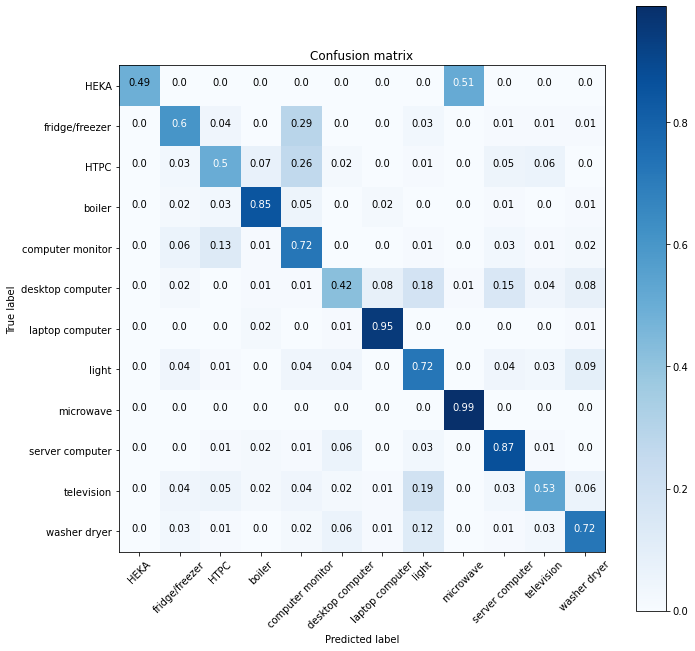

In [34]:
#Print results and plot confusion matrix

#print('Test accuracy: ', results[1])
#print("Loss: "f"{results[0]}")
Y_pred = model_used.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
C = confusion_matrix(Y_test, y_pred)
# B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)
print(confusion_matrix(Y_test, y_pred))
precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
print("F1 SCORE",fscore)
plot_confusion_matrix_norm(C, appliances, normalize=True)
print(classification_report(Y_test, y_pred, target_names=appliances))

In [52]:
for dataset in datasets_test:
    print(dataset[1])

model_0
model_1
model_3
model_1
model_6
model_1
model_2
model_3
model_4


testing dataset  auto_classic6 model  model_0


2021-11-06 16:49:32.954745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-06 16:49:32.955622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-11-06 16:49:32.955965: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-11-06 16:49:33.808682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-06 16:49:33.808717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-11-06 16:49:33.808834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-11-06 16:49:33.810000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

model exist, reading is done!


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-06 16:49:39.392636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-06 16:49:39.412240: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/30


2021-11-06 16:49:40.628963: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-11-06 16:49:41.395048: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-11-06 16:49:42.327236: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-06 16:49:43.120021: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2701/2701 - 27s - loss: 0.8374 - accuracy: 0.7121 - val_loss: 0.6429 - val_accuracy: 0.7780
Epoch 2/30
2701/2701 - 22s - loss: 0.6781 - accuracy: 0.7641 - val_loss: 0.6126 - val_accuracy: 0.7963
Epoch 3/30
2701/2701 - 22s - loss: 0.6358 - accuracy: 0.7784 - val_loss: 0.5863 - val_accuracy: 0.7982
Epoch 4/30
2701/2701 - 22s - loss: 0.6145 - accuracy: 0.7875 - val_loss: 0.6130 - val_accuracy: 0.7943
Epoch 5/30
2701/2701 - 22s - loss: 0.5928 - accuracy: 0.7953 - val_loss: 0.5647 - val_accuracy: 0.7921
Epoch 6/30
2701/2701 - 22s - loss: 0.5732 - accuracy: 0.8015 - val_loss: 0.6599 - val_accuracy: 0.7623
Epoch 7/30
2701/2701 - 22s - loss: 0.5632 - accuracy: 0.8027 - val_loss: 0.5448 - val_accuracy: 0.8058
Epoch 8/30
2701/2701 - 22s - loss: 0.5515 - accuracy: 0.8070 - val_loss: 0.5272 - val_accuracy: 0.8206
Epoch 9/30
2701/2701 - 22s - loss: 0.5479 - accuracy: 0.8081 - val_loss: 0.5361 - val_accuracy: 0.8158
Epoch 10/30
2701/2701 - 22s - loss: 0.5430 - accuracy: 0.8101 - val_loss: 0.5419 - v

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
2701/2701 - 29s - loss: 0.8835 - accuracy: 0.6985 - val_loss: 0.7299 - val_accuracy: 0.7569
Epoch 2/30
2701/2701 - 26s - loss: 0.7242 - accuracy: 0.7511 - val_loss: 0.6493 - val_accuracy: 0.7404
Epoch 3/30
2701/2701 - 26s - loss: 0.6838 - accuracy: 0.7612 - val_loss: 0.5636 - val_accuracy: 0.8004
Epoch 4/30
2701/2701 - 26s - loss: 0.6580 - accuracy: 0.7712 - val_loss: 0.5754 - val_accuracy: 0.7973
Epoch 5/30
2701/2701 - 26s - loss: 0.6342 - accuracy: 0.7784 - val_loss: 0.5511 - val_accuracy: 0.8124
Epoch 6/30
2701/2701 - 26s - loss: 0.6265 - accuracy: 0.7809 - val_loss: 0.5458 - val_accuracy: 0.8006
Epoch 7/30
2701/2701 - 26s - loss: 0.6132 - accuracy: 0.7837 - val_loss: 0.5370 - val_accuracy: 0.8124
Epoch 8/30
2701/2701 - 26s - loss: 0.6009 - accuracy: 0.7895 - val_loss: 0.5291 - val_accuracy: 0.8148
Epoch 9/30
2701/2701 - 26s - loss: 0.6062 - accuracy: 0.7898 - val_loss: 0.5156 - val_accuracy: 0.8271
Epoch 10/30
2701/2701 - 26s - loss: 0.5973 - accuracy: 0.7905 - val_loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
2701/2701 - 40s - loss: 0.9665 - accuracy: 0.6554 - val_loss: 0.7782 - val_accuracy: 0.7339
Epoch 2/30
2701/2701 - 37s - loss: 0.7695 - accuracy: 0.7312 - val_loss: 0.6269 - val_accuracy: 0.7897
Epoch 3/30
2701/2701 - 38s - loss: 0.7224 - accuracy: 0.7456 - val_loss: 0.6138 - val_accuracy: 0.7812
Epoch 4/30
2701/2701 - 37s - loss: 0.7039 - accuracy: 0.7541 - val_loss: 0.5633 - val_accuracy: 0.8086
Epoch 5/30
2701/2701 - 37s - loss: 0.6785 - accuracy: 0.7592 - val_loss: 0.6131 - val_accuracy: 0.7865
Epoch 6/30
2701/2701 - 37s - loss: 0.6698 - accuracy: 0.7637 - val_loss: 0.5762 - val_accuracy: 0.7949
Epoch 7/30
2701/2701 - 37s - loss: 0.6599 - accuracy: 0.7640 - val_loss: 0.5612 - val_accuracy: 0.7986
Epoch 8/30
2701/2701 - 37s - loss: 0.6522 - accuracy: 0.7703 - val_loss: 0.5575 - val_accuracy: 0.8043
Epoch 9/30
2701/2701 - 37s - loss: 0.6427 - accuracy: 0.7708 - val_loss: 0.5474 - val_accuracy: 0.8117
Epoch 10/30
2701/2701 - 38s - loss: 0.6376 - accuracy: 0.7739 - val_loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
2701/2701 - 40s - loss: 0.8950 - accuracy: 0.6859 - val_loss: 0.7133 - val_accuracy: 0.7482
Epoch 2/30
2701/2701 - 37s - loss: 0.6987 - accuracy: 0.7571 - val_loss: 0.7251 - val_accuracy: 0.7471
Epoch 3/30
2701/2701 - 37s - loss: 0.6509 - accuracy: 0.7711 - val_loss: 0.6539 - val_accuracy: 0.7808
Epoch 4/30
2701/2701 - 37s - loss: 0.6247 - accuracy: 0.7780 - val_loss: 0.5340 - val_accuracy: 0.8123
Epoch 5/30
2701/2701 - 37s - loss: 0.5945 - accuracy: 0.7903 - val_loss: 0.5808 - val_accuracy: 0.7917
Epoch 6/30
2701/2701 - 37s - loss: 0.5842 - accuracy: 0.7930 - val_loss: 0.5300 - val_accuracy: 0.8184
Epoch 7/30
2701/2701 - 37s - loss: 0.5699 - accuracy: 0.7992 - val_loss: 0.5356 - val_accuracy: 0.8089
Epoch 8/30
2701/2701 - 37s - loss: 0.5637 - accuracy: 0.8016 - val_loss: 0.5227 - val_accuracy: 0.8126
Epoch 9/30
2701/2701 - 37s - loss: 0.5533 - accuracy: 0.8004 - val_loss: 0.5077 - val_accuracy: 0.8274
Epoch 10/30
2701/2701 - 37s - loss: 0.5426 - accuracy: 0.8081 - val_loss:

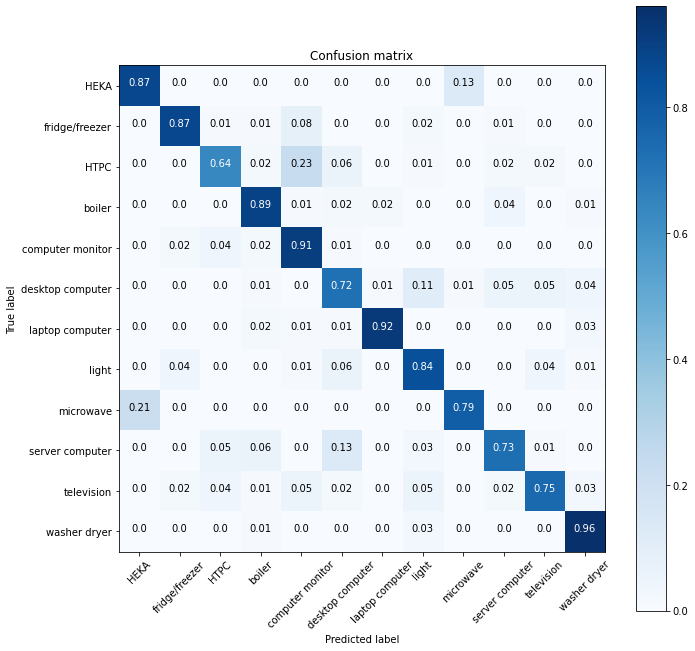

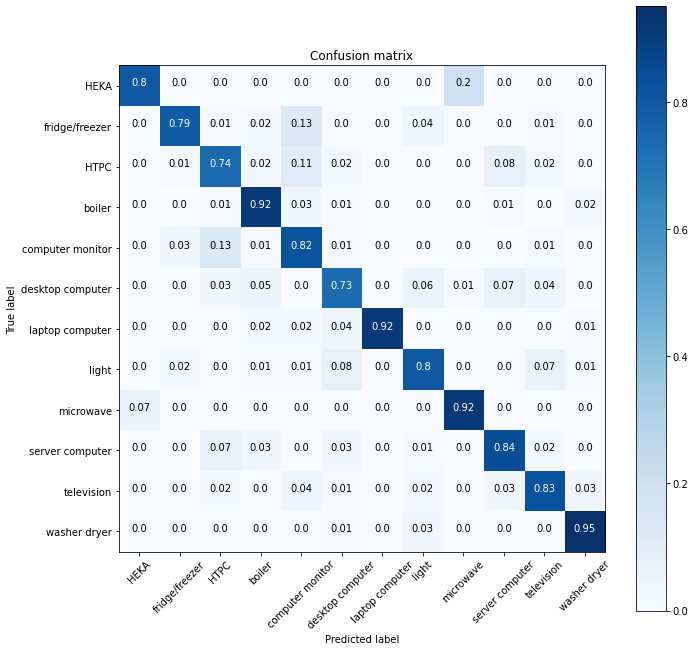

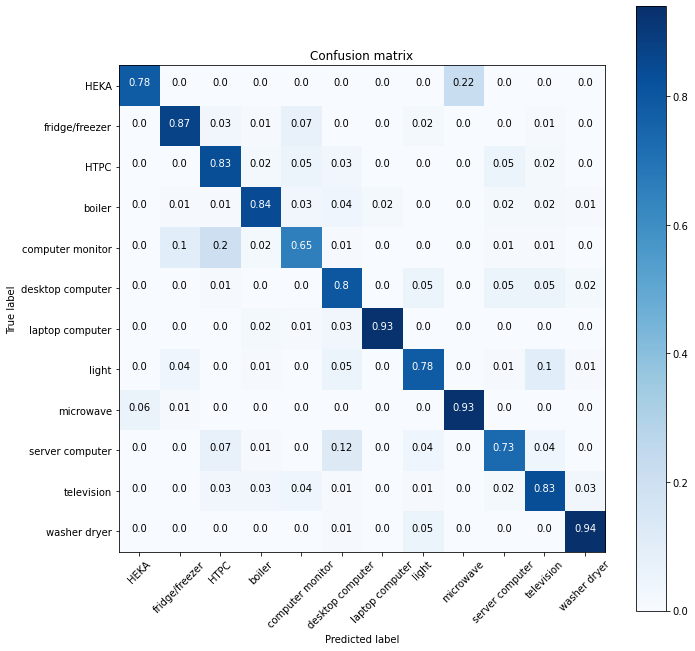

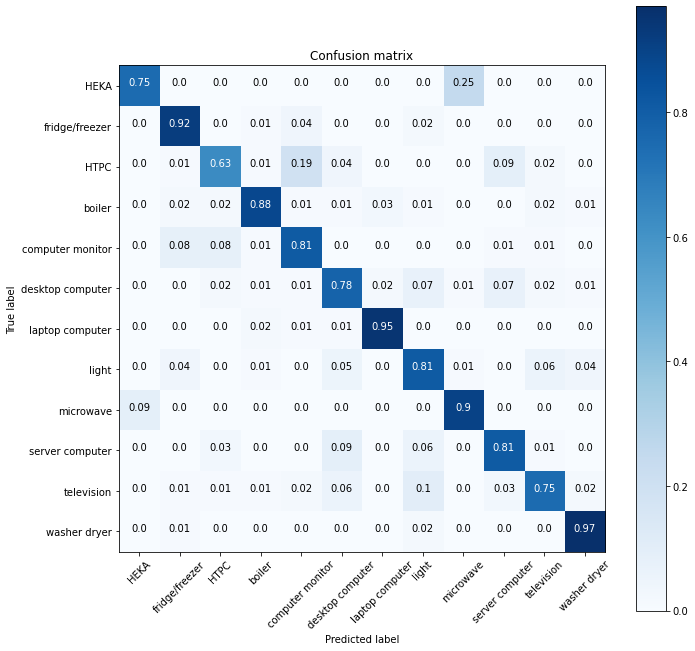

In [44]:
datasets_test = ["auto_classic6"]
models_test = ["model_0","model_1","model_2","model_3","model_4"]

datasets_test = [
                 ["auto_classic6","model_0"],
                 ["auto_classic4","model_1"],
                 ["auto_classic4","model_3"],
                 ["auto_classic5","model_1"],
                 ["auto_classic5","model_6"],
                 ["auto_classic6","model_1"],
                 ["auto_classic6","model_2"],
                 ["auto_classic6","model_3"],
                 ["auto_classic6","model_4"]
                ]
datasets_test = [
                 ["auto_classic6","model_0"],
                 ["auto_classic4","model_1"],
                 ["auto_classic6","model_3"],
                 ["auto_classic6","model_4"]
                ]

#models_test = ["model_0","model_1","model_2","model_3","model_4"]
for dataset in datasets_test:
    #for model in models_test:
        
        
        print("testing dataset ",dataset[0],"model ", dataset[1])
        path_model = dir_path+"/models/"+dataset[0]+"/"+dataset[1]#+"/model1"


        #path_model = dir_path+"/models/model_classic3"
        #path_model = dir_path+"/models/gen/model_gen"
        try:
            model = keras.models.load_model(path_model)
            print("model exist, reading is done!")
        except:
            print("model does not exist")
            continue

        #create trasfer learning model 
        model.trainable = False
        base_output = model.layers[-2].output
        hidden6 = Dense(2000, activation='relu')(base_output)
        hidden5 = Dense(300, activation='relu')(hidden6)
        hidden4 = Dense(64, activation='relu')(hidden5)
        hidden3 = Dense(32, activation='relu')(hidden4)
        hidden2 = Dense(16, activation='relu')(hidden3)
        hidden = Dense(num_of_classes, activation='softmax')(hidden2)

        model2 = keras.models.Model(model.inputs, hidden)
        lr = 0.002
        adam = optimizers.Adam(lr = lr)
        model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

        #trian
        model_used = model2

        model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 30, verbose = 2,callbacks=ClearMemory())
        results = model_used.evaluate(X_test, y_test, verbose = 2)
        print('Test accuracy: ', results[1])

        #Print results and plot confusion matrix

        #print('Test accuracy: ', results[1])
        #print("Loss: "f"{results[0]}")
        Y_pred = model_used.predict(X_test, verbose = 2)
        y_pred = np.argmax(Y_pred, axis=1)
        Y_test = np.argmax(y_test, axis=-1)
        C = confusion_matrix(Y_test, y_pred)
        # B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)
        print(confusion_matrix(Y_test, y_pred))
        precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
        print("F1 SCORE",fscore)
        plot_confusion_matrix_norm(C, appliances, normalize=True)
        print(classification_report(Y_test, y_pred, target_names=appliances))
        
        del model_used
        del model
        del model2

In [ ]:
#kfold with random seed
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []
seed_per_fold = []

for seed in range(10,500,5):
    #print("TRAIN:", train_index, "TEST:", test_index)
        
    X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=seed, stratify=y_anomF)
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 0)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    precision_per_fold.append(round(precision,4))
    recall_per_fold.append(round(recall,4))
    seed_per_fold.append(seed)


    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    print('test f1: ',f1_per_fold[-1])

In [285]:
for n,a in enumerate(appliances):
    num_samples = np.where(labels == n)[0].shape[0]
    step_size = num_samples/10
    print(a,n,num_samples,len(list(range(0,num_samples,int(step_size)))))
                                              

HEKA 0 750 10
fridge/freezer 1 750 10
HTPC 2 750 10
boiler 3 750 10
computer monitor 4 750 10
desktop computer 5 750 10
dish washer 6 750 10
laptop computer 7 750 10
light 8 750 10
microwave 9 750 10
server computer 10 750 10
television 11 750 10
washer dryer 12 750 10


In [116]:
## test dependecy of number of samples to performace 

#define prec, recall and F1 for each class
# prec0, prec1, prec2, prec3, prec4, prec5, prec6 = ([] for i in range(7))
# precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6]
# rec0, rec1, rec2, rec3, rec4, rec5, rec6 = ([] for i in range(7))
# recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6]
# F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6 = ([] for i in range(7))
# F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6]

prec0, prec1, prec2, prec3, prec4, prec5, prec6, prec7, prec8, prec9, prec10, prec11,prec12  = ([] for i in range(13))
precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6, prec9, prec10, prec11,prec12  ]
rec0, rec1, rec2, rec3, rec4, rec5, rec6, rec7, rec8, rec9, rec10, rec11, rec12 = ([] for i in range(13))
recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6, rec7, rec8, rec9, rec10,rec11, rec12]
F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6, F1_7, F1_8, F1_9, F1_10, F1_11, F1_12 = ([] for i in range(13))
F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6, F1_7, F1_8, F1_9, F1_10, F1_11, F1_12 ]

#counts arr

counts_arr_main = []
#main split

num_of_classes = len(appliances)
#data = 0;
#labels = 0

size_ds = 750
counts_arr = []
for split_size in range(1,int(size_ds*.8),50):
    train_size = split_size/size_ds
    X_train, X_test, y_train, y_test = train_test_split(data, labels,train_size=train_size, test_size=int(size_ds*0.2), random_state=42,stratify=labels)

    values, counts = np.unique(y_train,return_counts=True)
    print("train %",train_size*100,"items ",split_size,"counts",counts)


     #if i > 2:
     #    break


    #split all
    print("splitting train size %",round(train_size*100,2))
    
    print("instances in array",values.shape)
    print("unique instances",np.unique(values).shape)

    
    print("appending counts :",counts)
    counts_arr.append(counts)

    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)

    #reset model and compile it again
#     model.trainable = False
#     base_output = model.layers[-2].output
#     #hidden4 = Dense(64, activation='softmax')(base_output)
#     hidden3 = Dense(32, activation='softmax')(base_output)
#     hidden2 = Dense(16, activation='softmax')(hidden3)
#     hidden = Dense(num_of_classes, activation='softmax')(hidden2)

#     model2 = keras.models.Model(model.inputs, hidden)
#     lr = 0.002
#     adam = optimizers.Adam(lr = lr)
#     model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        
    model2 = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    print("xtrain2",X_train.shape)
    print("ytrain2",y_train.shape[0])
    print("ytest2",y_test.shape[0])
    
    model_used = model2
    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 50, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])

    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)

    #Calculate metrics. IMPORTANT use labels that the scores will be correct for each class
    metrics = score(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10,11,12])

    #del model_used
    #del model2

    #append prec, rec and F1 for each individual class
    for k,j in enumerate(precission):
        #if k == appliance_index:
            j.append(metrics[0][k])

    for k,j in enumerate(recall):
        #if k == appliance_index:
            j.append(metrics[1][k])

    for k,j in enumerate(F1):
        #if k == appliance_index:
            j.append(metrics[2][k])

    


train % 0.13333333333333333 items  1 counts [1 1 1 1 1 1 1 1 1 1 1 1 1]
splitting train size % 0.13
instances in array (13,)
unique instances (13,)
appending counts : [1 1 1 1 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (13, 5, 100, 100, 1)
yt2 (13, 13)
Epoch 1/50
2/2 - 2s - loss: 2.6368 - accuracy: 0.1000 - val_loss: 2.6635 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 - 0s - loss: 2.5799 - accuracy: 0.1000 - val_loss: 2.6638 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 - 0s - loss: 2.5643 - accuracy: 0.1000 - val_loss: 2.6673 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 - 0s - loss: 2.6026 - accuracy: 0.0000e+00 - val_loss: 2.6709 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 - 0s - loss: 2.5330 - accuracy: 0.0000e+00 - val_loss: 2.6742 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 - 0s - loss: 2.6281 - accuracy: 0.0000e+00 - val_loss: 2.6771 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 - 0s - loss: 2.6064 - accuracy: 0.1000 - val_loss: 2.6793 - val_accuracy: 0.0000e+00
Epoch 8/50
2/2 - 0s - loss: 2.5839 - accuracy: 0.0000e+00 - val_loss: 2.6813 - val_accuracy: 0.0000e+00
Epoch 9/50
2/2 - 0s - loss: 2.6984 - accuracy: 0.0000e+00 - val_loss: 2.6825 - val_accuracy: 0.0000e+00
Epoch 10/50
2/2 - 0s - loss: 2.6082 - accu

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (663, 5, 100, 100, 1)
yt2 (663, 13)
Epoch 1/50
67/67 - 3s - loss: 2.6014 - accuracy: 0.0868 - val_loss: 2.5719 - val_accuracy: 0.0977
Epoch 2/50
67/67 - 1s - loss: 2.5227 - accuracy: 0.1151 - val_loss: 2.4879 - val_accuracy: 0.1429
Epoch 3/50
67/67 - 1s - loss: 2.4624 - accuracy: 0.1642 - val_loss: 2.4389 - val_accuracy: 0.1579
Epoch 4/50
67/67 - 1s - loss: 2.4186 - accuracy: 0.1887 - val_loss: 2.4182 - val_accuracy: 0.1880
Epoch 5/50
67/67 - 1s - loss: 2.3773 - accuracy: 0.1943 - val_loss: 2.3789 - val_accuracy: 0.1805
Epoch 6/50
67/67 - 1s - loss: 2.3331 - accuracy: 0.2170 - val_loss: 2.3523 - val_accuracy: 0.2180
Epoch 7/50
67/67 - 1s - loss: 2.3163 - accuracy: 0.2358 - val_loss: 2.3203 - val_accuracy: 0.2256
Epoch 8/50
67/67 - 1s - loss: 2.2685 - accuracy: 0.2547 - val_loss: 2.2928 - val_accuracy: 0.2406
Epoch 9/50
67/67 - 1s - loss: 2.2320 - accuracy: 0.2623 - val_loss: 2.2592 - val_accuracy: 0.2707
Epoch 10/50
67/67 - 1s - loss: 2.1984 - accuracy: 0.2925 - val_loss: 2.2547 - 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (1313, 5, 100, 100, 1)
yt2 (1313, 13)
Epoch 1/50
132/132 - 3s - loss: 2.5227 - accuracy: 0.1210 - val_loss: 2.4507 - val_accuracy: 0.1521
Epoch 2/50
132/132 - 2s - loss: 2.4701 - accuracy: 0.1295 - val_loss: 2.3978 - val_accuracy: 0.2015
Epoch 3/50
132/132 - 2s - loss: 2.4333 - accuracy: 0.1943 - val_loss: 2.3581 - val_accuracy: 0.2471
Epoch 4/50
132/132 - 2s - loss: 2.3985 - accuracy: 0.2190 - val_loss: 2.3244 - val_accuracy: 0.2814
Epoch 5/50
132/132 - 2s - loss: 2.3619 - accuracy: 0.2467 - val_loss: 2.2779 - val_accuracy: 0.2890
Epoch 6/50
132/132 - 2s - loss: 2.3198 - accuracy: 0.2714 - val_loss: 2.2348 - val_accuracy: 0.3080
Epoch 7/50
132/132 - 2s - loss: 2.2607 - accuracy: 0.3029 - val_loss: 2.1767 - val_accuracy: 0.3308
Epoch 8/50
132/132 - 2s - loss: 2.2014 - accuracy: 0.3257 - val_loss: 2.1195 - val_accuracy: 0.3232
Epoch 9/50
132/132 - 2s - loss: 2.1332 - accuracy: 0.3495 - val_loss: 2.0282 - val_accuracy: 0.4221
Epoch 10/50
132/132 - 2s - loss: 2.0637 - accuracy: 0.3886

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (1963, 5, 100, 100, 1)
yt2 (1963, 13)
Epoch 1/50
197/197 - 4s - loss: 2.5622 - accuracy: 0.0949 - val_loss: 2.4797 - val_accuracy: 0.1552
Epoch 2/50
197/197 - 2s - loss: 2.4924 - accuracy: 0.1490 - val_loss: 2.4063 - val_accuracy: 0.1603
Epoch 3/50
197/197 - 2s - loss: 2.4114 - accuracy: 0.1675 - val_loss: 2.3406 - val_accuracy: 0.1959
Epoch 4/50
197/197 - 2s - loss: 2.3595 - accuracy: 0.2159 - val_loss: 2.2960 - val_accuracy: 0.2570
Epoch 5/50
197/197 - 2s - loss: 2.3050 - accuracy: 0.2605 - val_loss: 2.2487 - val_accuracy: 0.2901
Epoch 6/50
197/197 - 2s - loss: 2.2780 - accuracy: 0.2796 - val_loss: 2.1976 - val_accuracy: 0.3537
Epoch 7/50
197/197 - 2s - loss: 2.2248 - accuracy: 0.3376 - val_loss: 2.1449 - val_accuracy: 0.3766
Epoch 8/50
197/197 - 2s - loss: 2.1542 - accuracy: 0.3605 - val_loss: 2.1113 - val_accuracy: 0.3969
Epoch 9/50
197/197 - 2s - loss: 2.0989 - accuracy: 0.3777 - val_loss: 2.0145 - val_accuracy: 0.4300
Epoch 10/50
197/197 - 2s - loss: 2.0260 - accuracy: 0.3803

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (2613, 5, 100, 100, 1)
yt2 (2613, 13)
Epoch 1/50
262/262 - 5s - loss: 2.5331 - accuracy: 0.1512 - val_loss: 2.4549 - val_accuracy: 0.1931
Epoch 2/50
262/262 - 3s - loss: 2.4334 - accuracy: 0.1933 - val_loss: 2.3839 - val_accuracy: 0.2333
Epoch 3/50
262/262 - 3s - loss: 2.3551 - accuracy: 0.2646 - val_loss: 2.2954 - val_accuracy: 0.3442
Epoch 4/50
262/262 - 3s - loss: 2.2882 - accuracy: 0.3077 - val_loss: 2.2388 - val_accuracy: 0.3728
Epoch 5/50
262/262 - 3s - loss: 2.2215 - accuracy: 0.3469 - val_loss: 2.1663 - val_accuracy: 0.4034
Epoch 6/50
262/262 - 3s - loss: 2.1429 - accuracy: 0.4072 - val_loss: 2.0917 - val_accuracy: 0.4283
Epoch 7/50
262/262 - 3s - loss: 2.0845 - accuracy: 0.4287 - val_loss: 2.0261 - val_accuracy: 0.4436
Epoch 8/50
262/262 - 3s - loss: 2.0204 - accuracy: 0.4598 - val_loss: 1.9896 - val_accuracy: 0.4532
Epoch 9/50
262/262 - 3s - loss: 1.9609 - accuracy: 0.4751 - val_loss: 1.9347 - val_accuracy: 0.4742
Epoch 10/50
262/262 - 3s - loss: 1.9115 - accuracy: 0.5000

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (3263, 5, 100, 100, 1)
yt2 (3263, 13)
Epoch 1/50
327/327 - 5s - loss: 2.5290 - accuracy: 0.1027 - val_loss: 2.4134 - val_accuracy: 0.1501
Epoch 2/50
327/327 - 4s - loss: 2.4140 - accuracy: 0.1529 - val_loss: 2.3123 - val_accuracy: 0.1914
Epoch 3/50
327/327 - 4s - loss: 2.2878 - accuracy: 0.2218 - val_loss: 2.1163 - val_accuracy: 0.3553
Epoch 4/50
327/327 - 4s - loss: 2.1157 - accuracy: 0.3146 - val_loss: 1.9662 - val_accuracy: 0.3813
Epoch 5/50
327/327 - 4s - loss: 1.9736 - accuracy: 0.3743 - val_loss: 1.8519 - val_accuracy: 0.4456
Epoch 6/50
327/327 - 4s - loss: 1.8476 - accuracy: 0.4540 - val_loss: 1.7400 - val_accuracy: 0.4625
Epoch 7/50
327/327 - 4s - loss: 1.7651 - accuracy: 0.4900 - val_loss: 1.6649 - val_accuracy: 0.5314
Epoch 8/50
327/327 - 4s - loss: 1.6934 - accuracy: 0.5061 - val_loss: 1.6114 - val_accuracy: 0.5207
Epoch 9/50
327/327 - 4s - loss: 1.6501 - accuracy: 0.5314 - val_loss: 1.5550 - val_accuracy: 0.5697
Epoch 10/50
327/327 - 4s - loss: 1.6008 - accuracy: 0.5651

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (3913, 5, 100, 100, 1)
yt2 (3913, 13)
Epoch 1/50
392/392 - 6s - loss: 2.5347 - accuracy: 0.0923 - val_loss: 2.4449 - val_accuracy: 0.1047
Epoch 2/50
392/392 - 5s - loss: 2.4282 - accuracy: 0.1495 - val_loss: 2.3741 - val_accuracy: 0.1724
Epoch 3/50
392/392 - 5s - loss: 2.3603 - accuracy: 0.2144 - val_loss: 2.2973 - val_accuracy: 0.2746
Epoch 4/50
392/392 - 5s - loss: 2.2572 - accuracy: 0.2914 - val_loss: 2.1707 - val_accuracy: 0.3423
Epoch 5/50
392/392 - 5s - loss: 2.1349 - accuracy: 0.3741 - val_loss: 2.0240 - val_accuracy: 0.4049
Epoch 6/50
392/392 - 5s - loss: 2.0047 - accuracy: 0.4016 - val_loss: 1.9360 - val_accuracy: 0.4444
Epoch 7/50
392/392 - 5s - loss: 1.9025 - accuracy: 0.4700 - val_loss: 1.8173 - val_accuracy: 0.5338
Epoch 8/50
392/392 - 5s - loss: 1.8267 - accuracy: 0.5134 - val_loss: 1.7595 - val_accuracy: 0.5543
Epoch 9/50
392/392 - 5s - loss: 1.7758 - accuracy: 0.5173 - val_loss: 1.6959 - val_accuracy: 0.5875
Epoch 10/50
392/392 - 5s - loss: 1.7040 - accuracy: 0.5537

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (4563, 5, 100, 100, 1)
yt2 (4563, 13)
Epoch 1/50
457/457 - 7s - loss: 2.5493 - accuracy: 0.1236 - val_loss: 2.4506 - val_accuracy: 0.1544
Epoch 2/50
457/457 - 5s - loss: 2.4498 - accuracy: 0.1797 - val_loss: 2.3376 - val_accuracy: 0.2673
Epoch 3/50
457/457 - 5s - loss: 2.3404 - accuracy: 0.2690 - val_loss: 2.2164 - val_accuracy: 0.3746
Epoch 4/50
457/457 - 5s - loss: 2.2465 - accuracy: 0.3400 - val_loss: 2.1025 - val_accuracy: 0.4348
Epoch 5/50
457/457 - 5s - loss: 2.1395 - accuracy: 0.3868 - val_loss: 1.9757 - val_accuracy: 0.4578
Epoch 6/50
457/457 - 5s - loss: 2.0030 - accuracy: 0.4299 - val_loss: 1.8638 - val_accuracy: 0.5148
Epoch 7/50
457/457 - 5s - loss: 1.9034 - accuracy: 0.4636 - val_loss: 1.8060 - val_accuracy: 0.5214
Epoch 8/50
457/457 - 5s - loss: 1.8412 - accuracy: 0.4822 - val_loss: 1.7398 - val_accuracy: 0.5411
Epoch 9/50
457/457 - 5s - loss: 1.7779 - accuracy: 0.5071 - val_loss: 1.6737 - val_accuracy: 0.5553
Epoch 10/50
457/457 - 5s - loss: 1.7233 - accuracy: 0.5260

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (5213, 5, 100, 100, 1)
yt2 (5213, 13)
Epoch 1/50
522/522 - 8s - loss: 2.4973 - accuracy: 0.1482 - val_loss: 2.3931 - val_accuracy: 0.2109
Epoch 2/50
522/522 - 6s - loss: 2.3617 - accuracy: 0.2264 - val_loss: 2.2560 - val_accuracy: 0.2560
Epoch 3/50
522/522 - 6s - loss: 2.2449 - accuracy: 0.2899 - val_loss: 2.1103 - val_accuracy: 0.3615
Epoch 4/50
522/522 - 6s - loss: 2.1226 - accuracy: 0.3823 - val_loss: 1.9907 - val_accuracy: 0.4430
Epoch 5/50
522/522 - 6s - loss: 1.9928 - accuracy: 0.4518 - val_loss: 1.8508 - val_accuracy: 0.5139
Epoch 6/50
522/522 - 6s - loss: 1.8494 - accuracy: 0.4954 - val_loss: 1.7250 - val_accuracy: 0.5360
Epoch 7/50
522/522 - 6s - loss: 1.7495 - accuracy: 0.5036 - val_loss: 1.6335 - val_accuracy: 0.5312
Epoch 8/50
522/522 - 6s - loss: 1.6532 - accuracy: 0.5213 - val_loss: 1.5558 - val_accuracy: 0.5638
Epoch 9/50
522/522 - 6s - loss: 1.5858 - accuracy: 0.5501 - val_loss: 1.5006 - val_accuracy: 0.5954
Epoch 10/50
522/522 - 6s - loss: 1.5265 - accuracy: 0.5755

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (5863, 5, 100, 100, 1)
yt2 (5863, 13)
Epoch 1/50
587/587 - 8s - loss: 2.4723 - accuracy: 0.1469 - val_loss: 2.3202 - val_accuracy: 0.2549
Epoch 2/50
587/587 - 7s - loss: 2.2910 - accuracy: 0.2774 - val_loss: 2.2109 - val_accuracy: 0.3581
Epoch 3/50
587/587 - 7s - loss: 2.1588 - accuracy: 0.3595 - val_loss: 2.0698 - val_accuracy: 0.4160
Epoch 4/50
587/587 - 7s - loss: 2.0283 - accuracy: 0.4469 - val_loss: 1.9557 - val_accuracy: 0.4791
Epoch 5/50
587/587 - 7s - loss: 1.9018 - accuracy: 0.5264 - val_loss: 1.8265 - val_accuracy: 0.5499
Epoch 6/50
587/587 - 7s - loss: 1.7825 - accuracy: 0.5716 - val_loss: 1.7172 - val_accuracy: 0.5754
Epoch 7/50
587/587 - 7s - loss: 1.6764 - accuracy: 0.5977 - val_loss: 1.6737 - val_accuracy: 0.5823
Epoch 8/50
587/587 - 7s - loss: 1.5885 - accuracy: 0.6183 - val_loss: 1.5348 - val_accuracy: 0.6215
Epoch 9/50
587/587 - 7s - loss: 1.5180 - accuracy: 0.6377 - val_loss: 1.4843 - val_accuracy: 0.6053
Epoch 10/50
587/587 - 7s - loss: 1.4569 - accuracy: 0.6467

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (6513, 5, 100, 100, 1)
yt2 (6513, 13)
Epoch 1/50
652/652 - 9s - loss: 2.3793 - accuracy: 0.1476 - val_loss: 2.1808 - val_accuracy: 0.2218
Epoch 2/50
652/652 - 8s - loss: 2.1529 - accuracy: 0.2564 - val_loss: 2.0237 - val_accuracy: 0.3369
Epoch 3/50
652/652 - 8s - loss: 2.0223 - accuracy: 0.3509 - val_loss: 1.9432 - val_accuracy: 0.3960
Epoch 4/50
652/652 - 8s - loss: 1.9008 - accuracy: 0.4534 - val_loss: 1.7988 - val_accuracy: 0.5042
Epoch 5/50
652/652 - 8s - loss: 1.7582 - accuracy: 0.5203 - val_loss: 1.6445 - val_accuracy: 0.5426
Epoch 6/50
652/652 - 8s - loss: 1.6188 - accuracy: 0.5689 - val_loss: 1.5299 - val_accuracy: 0.5863
Epoch 7/50
652/652 - 8s - loss: 1.5105 - accuracy: 0.6054 - val_loss: 1.4198 - val_accuracy: 0.6531
Epoch 8/50
652/652 - 8s - loss: 1.4222 - accuracy: 0.6390 - val_loss: 1.3510 - val_accuracy: 0.6769
Epoch 9/50
652/652 - 8s - loss: 1.3434 - accuracy: 0.6691 - val_loss: 1.3053 - val_accuracy: 0.6961
Epoch 10/50
652/652 - 8s - loss: 1.2772 - accuracy: 0.6987

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (7163, 5, 100, 100, 1)
yt2 (7163, 13)
Epoch 1/50
717/717 - 10s - loss: 2.3612 - accuracy: 0.1956 - val_loss: 2.0659 - val_accuracy: 0.3685
Epoch 2/50
717/717 - 8s - loss: 2.0052 - accuracy: 0.4182 - val_loss: 1.8094 - val_accuracy: 0.4962
Epoch 3/50
717/717 - 8s - loss: 1.8121 - accuracy: 0.5243 - val_loss: 1.6298 - val_accuracy: 0.5939
Epoch 4/50
717/717 - 8s - loss: 1.6568 - accuracy: 0.5986 - val_loss: 1.4860 - val_accuracy: 0.6699
Epoch 5/50
717/717 - 8s - loss: 1.5050 - accuracy: 0.6461 - val_loss: 1.3534 - val_accuracy: 0.7062
Epoch 6/50
717/717 - 8s - loss: 1.3926 - accuracy: 0.6675 - val_loss: 1.2702 - val_accuracy: 0.7216
Epoch 7/50
717/717 - 8s - loss: 1.3137 - accuracy: 0.6918 - val_loss: 1.1890 - val_accuracy: 0.7411
Epoch 8/50
717/717 - 8s - loss: 1.2385 - accuracy: 0.7173 - val_loss: 1.1514 - val_accuracy: 0.7425
Epoch 9/50
717/717 - 8s - loss: 1.1816 - accuracy: 0.7281 - val_loss: 1.1053 - val_accuracy: 0.7530
Epoch 10/50
717/717 - 8s - loss: 1.1275 - accuracy: 0.747

In [121]:
#stored resutls
counts_arr_stored_6 = counts_arr
F1_stored_6 = F1
recall_stored_6 = recall
precission_stored_6 = precission
appliances_6 = appliances

%store precission_stored_6
%store F1_stored_6
%store recall_stored_6
%store counts_arr_stored_6
%store appliances_6

#1- test 30 samples variating step - hard to average
#2 1200 samples 30 epochs step of 10 11 classes (Trasfer learning modelclassic3 )
#3 1200 samples 100 epochs step of 10 11 classes (lstm3d normal)
#4 750 samlkes 100 epochs step of 10 (last two classes missing) (lstm3d normal)11 classes (should be 13) count that in when graphing average
#5 1500 samples 50 epochs step of 50 (all classes)(lstm3d normal)
#6 same as #4 except that i used 50 epochs and step of 50. 13 classes (no bug)

Stored 'precission_stored_6' (list)
Stored 'F1_stored_6' (list)
Stored 'recall_stored_6' (list)
Stored 'counts_arr_stored_6' (list)
Stored 'appliances_6' (list)


In [133]:
%store

Stored variables and their in-db values:
F1_stored                          -> [[0.0, 0.0, 0.18181818181818182, 0.476190476190476
F1_stored_2                        -> [[0.0, 0.0, 0.0, 0.972972972972973, 1.0, 1.0, 1.0,
F1_stored_3                        -> [[0.13793103448275865, 0.0, 0.3225806451612903, 0.
F1_stored_4                        -> [[0.0, 0.5789473684210527, 0.47058823529411764, 0.
F1_stored_5                        -> [[0.0, 0.5945945945945946, 0.6818181818181819, 0.7
F1_stored_6                        -> [[0.0, 0.2608695652173913, 0.7199999999999999, 0.6
appliances_2                       -> ['toaster', 'boiler', 'laptop computer', 'computer
appliances_3                       -> ['HTPC', 'boiler', 'computer monitor', 'desktop co
appliances_4                       -> ['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'comp
appliances_5                       -> ['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'comp
appliances_6                       -> ['HEKA', 'fridge/freezer', 'HTP

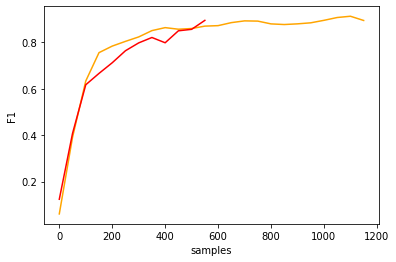

In [128]:
len_ap = len(appliances_4)
#plt.plot(np.array(counts_arr_stored_4)[:,1], np.sum(np.array(F1_stored_4),axis=0)/11, '-')
#plt.plot(np.array(counts_arr_stored_4)[:,1], savgol_filter(np.sum(np.array(F1_stored_4),axis=0)/11,5,1), '-',color="orange")
len_ap = len(appliances_5)
#plt.plot(np.array(counts_arr_stored_5)[:,1], np.sum(np.array(F1_stored_5)[:len_ap,:],axis=0)/len_ap, '-')
plt.plot(np.array(counts_arr_stored_5)[:,1], savgol_filter(np.sum(np.array(F1_stored_5)[:len_ap,:],axis=0)/len_ap,3,1), '-',color="orange")
len_ap = len(appliances)
plt.plot(np.array(counts_arr)[:,1], savgol_filter(np.sum(np.array(F1)[:len_ap,:],axis=0)/len_ap,3,1), '-',color="red")
#plt.plot(np.array(counts_arr)[:,1], np.sum(np.array(F1)[:len_ap,:],axis=0)/len_ap, '-')



plt.ylabel("F1")
plt.xlabel("samples")
plt.show()

0 HEKA


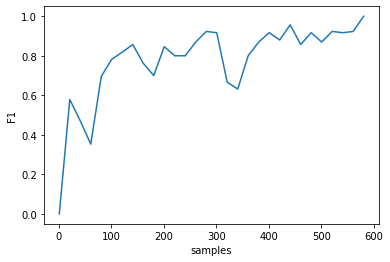

1 fridge/freezer


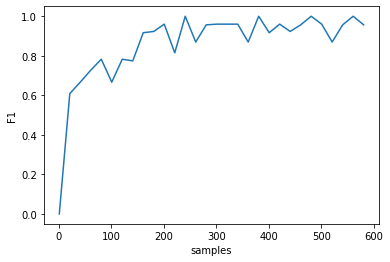

2 HTPC


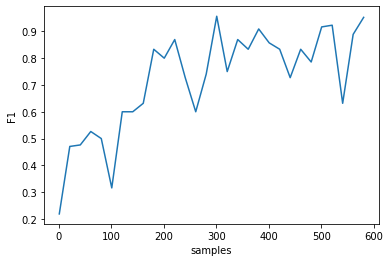

3 boiler


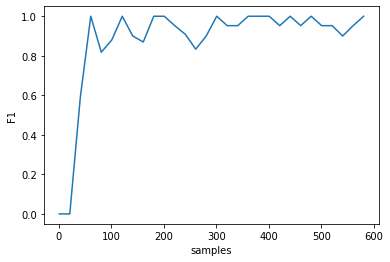

4 computer monitor


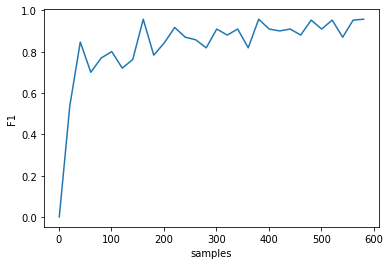

5 desktop computer


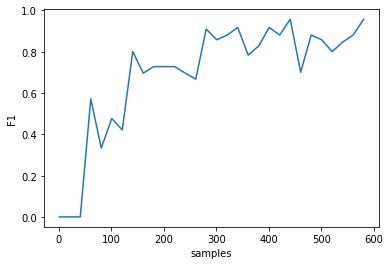

6 dish washer


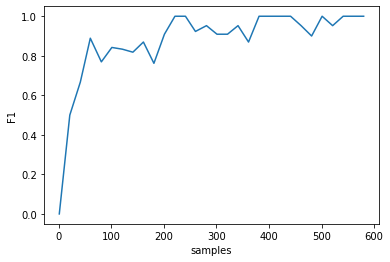

7 laptop computer


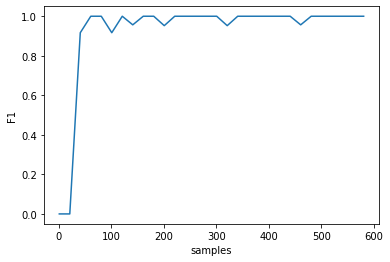

8 light


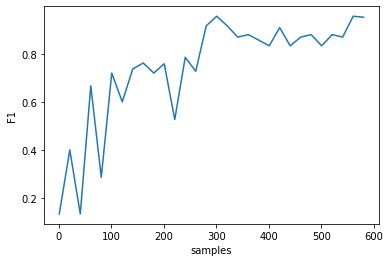

9 microwave


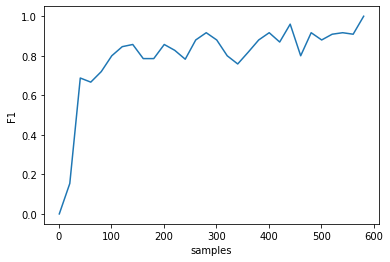

10 server computer


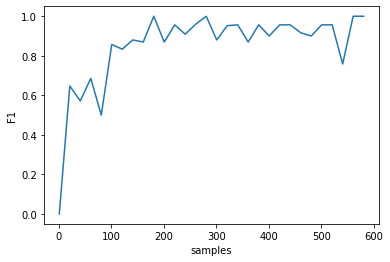

11 television


IndexError: index 11 is out of bounds for axis 0 with size 11

In [30]:
for i,e in enumerate(appliances):
    print(i,e)
    plt.plot(np.array(counts_arr)[:,i], np.array(F1)[i,:], '-')
    plt.ylabel("F1")
    plt.xlabel("samples")
    plt.show()

In [53]:
#automating model generation for various types of models 
i = 0
model_names = [LSTM_3D(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V61(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V62(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V63(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V64(X_train,num_of_classes,lr = 0.00002)]

for model in model_names:
      
    model_used = model
    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 80, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])
    
    path_model_classic = dir_path+"/models/auto_classic6/model_"+str(i)
    model_used.save(path_model_classic)
    i += 1
    
    print("removing model from ram")
    del model_used
    del model
    print("new model")

2021-11-05 14:06:25.720213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-05 14:06:25.740342: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/80


2021-11-05 14:06:26.951532: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-11-05 14:06:27.715411: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-11-05 14:06:28.631324: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-05 14:06:29.420038: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2903/2903 - 39s - loss: 2.3674 - accuracy: 0.2864 - val_loss: 2.0622 - val_accuracy: 0.4687
Epoch 2/80
2903/2903 - 33s - loss: 1.9465 - accuracy: 0.4780 - val_loss: 1.7984 - val_accuracy: 0.5168
Epoch 3/80
2903/2903 - 33s - loss: 1.7468 - accuracy: 0.5230 - val_loss: 1.6487 - val_accuracy: 0.5395
Epoch 4/80
2903/2903 - 33s - loss: 1.6220 - accuracy: 0.5430 - val_loss: 1.5505 - val_accuracy: 0.5525
Epoch 5/80
2903/2903 - 33s - loss: 1.5148 - accuracy: 0.5609 - val_loss: 1.4444 - val_accuracy: 0.5717
Epoch 6/80
2903/2903 - 33s - loss: 1.4219 - accuracy: 0.5743 - val_loss: 1.3817 - val_accuracy: 0.5711
Epoch 7/80
2903/2903 - 33s - loss: 1.3458 - accuracy: 0.5879 - val_loss: 1.3247 - val_accuracy: 0.5817
Epoch 8/80
2903/2903 - 33s - loss: 1.2728 - accuracy: 0.6094 - val_loss: 1.2244 - val_accuracy: 0.6315
Epoch 9/80
2903/2903 - 33s - loss: 1.2116 - accuracy: 0.6265 - val_loss: 1.1804 - val_accuracy: 0.6434
Epoch 10/80
2903/2903 - 33s - loss: 1.1522 - accuracy: 0.6480 - val_loss: 1.1288 - v

Epoch 80/80
2903/2903 - 33s - loss: 0.4139 - accuracy: 0.8655 - val_loss: 0.4692 - val_accuracy: 0.8415
227/227 - 3s - loss: 0.4554 - accuracy: 0.8467
Test accuracy:  0.8467475175857544


2021-11-05 14:51:02.071220: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_0/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_0/assets


removing model from ram
new model
Epoch 1/80
2903/2903 - 58s - loss: 2.2425 - accuracy: 0.3670 - val_loss: 1.8723 - val_accuracy: 0.4610
Epoch 2/80
2903/2903 - 55s - loss: 1.6660 - accuracy: 0.5124 - val_loss: 1.4908 - val_accuracy: 0.5213
Epoch 3/80
2903/2903 - 55s - loss: 1.3842 - accuracy: 0.5610 - val_loss: 1.2651 - val_accuracy: 0.5774
Epoch 4/80
2903/2903 - 55s - loss: 1.2010 - accuracy: 0.6050 - val_loss: 1.1083 - val_accuracy: 0.6451
Epoch 5/80
2903/2903 - 55s - loss: 1.0693 - accuracy: 0.6510 - val_loss: 1.0133 - val_accuracy: 0.6689
Epoch 6/80
2903/2903 - 55s - loss: 0.9898 - accuracy: 0.6693 - val_loss: 0.9505 - val_accuracy: 0.6866
Epoch 7/80
2903/2903 - 55s - loss: 0.9198 - accuracy: 0.6945 - val_loss: 0.9026 - val_accuracy: 0.6997
Epoch 8/80
2903/2903 - 55s - loss: 0.8689 - accuracy: 0.7128 - val_loss: 0.8542 - val_accuracy: 0.7137
Epoch 9/80
2903/2903 - 55s - loss: 0.8243 - accuracy: 0.7259 - val_loss: 0.8034 - val_accuracy: 0.7302
Epoch 10/80
2903/2903 - 55s - loss: 0.7

Epoch 80/80
2903/2903 - 55s - loss: 0.1942 - accuracy: 0.9327 - val_loss: 0.4498 - val_accuracy: 0.8472
227/227 - 4s - loss: 0.4346 - accuracy: 0.8516
Test accuracy:  0.8515711426734924


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_1/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_1/assets


removing model from ram
new model
Epoch 1/80
2903/2903 - 57s - loss: 2.1345 - accuracy: 0.3739 - val_loss: 1.7166 - val_accuracy: 0.5275
Epoch 2/80
2903/2903 - 54s - loss: 1.5261 - accuracy: 0.5734 - val_loss: 1.3327 - val_accuracy: 0.6186
Epoch 3/80
2903/2903 - 54s - loss: 1.2348 - accuracy: 0.6285 - val_loss: 1.1323 - val_accuracy: 0.6481
Epoch 4/80
2903/2903 - 54s - loss: 1.0740 - accuracy: 0.6580 - val_loss: 1.0265 - val_accuracy: 0.6675
Epoch 5/80
2903/2903 - 54s - loss: 0.9781 - accuracy: 0.6795 - val_loss: 0.9288 - val_accuracy: 0.6939
Epoch 6/80
2903/2903 - 54s - loss: 0.9086 - accuracy: 0.6971 - val_loss: 0.8700 - val_accuracy: 0.7152
Epoch 7/80
2903/2903 - 54s - loss: 0.8532 - accuracy: 0.7148 - val_loss: 0.8447 - val_accuracy: 0.7087
Epoch 8/80
2903/2903 - 54s - loss: 0.8072 - accuracy: 0.7258 - val_loss: 0.7976 - val_accuracy: 0.7273
Epoch 9/80
2903/2903 - 54s - loss: 0.7642 - accuracy: 0.7395 - val_loss: 0.7611 - val_accuracy: 0.7469
Epoch 10/80
2903/2903 - 54s - loss: 0.7

Epoch 80/80
2903/2903 - 54s - loss: 0.1386 - accuracy: 0.9549 - val_loss: 0.5192 - val_accuracy: 0.8291
227/227 - 4s - loss: 0.5168 - accuracy: 0.8379
Test accuracy:  0.8379272222518921


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_2/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_2/assets


removing model from ram
new model
Epoch 1/80
2903/2903 - 105s - loss: 2.3686 - accuracy: 0.2828 - val_loss: 2.0416 - val_accuracy: 0.4363
Epoch 2/80
2903/2903 - 102s - loss: 1.8133 - accuracy: 0.4848 - val_loss: 1.5609 - val_accuracy: 0.5156
Epoch 3/80
2903/2903 - 102s - loss: 1.4370 - accuracy: 0.5482 - val_loss: 1.2859 - val_accuracy: 0.5891
Epoch 4/80
2903/2903 - 102s - loss: 1.2365 - accuracy: 0.6021 - val_loss: 1.1079 - val_accuracy: 0.6319
Epoch 5/80
2903/2903 - 102s - loss: 1.1009 - accuracy: 0.6433 - val_loss: 1.0054 - val_accuracy: 0.6832
Epoch 6/80
2903/2903 - 102s - loss: 0.9924 - accuracy: 0.6816 - val_loss: 0.9149 - val_accuracy: 0.7077
Epoch 7/80
2903/2903 - 102s - loss: 0.9197 - accuracy: 0.7062 - val_loss: 0.8572 - val_accuracy: 0.7201
Epoch 8/80
2903/2903 - 102s - loss: 0.8621 - accuracy: 0.7224 - val_loss: 0.8189 - val_accuracy: 0.7363
Epoch 9/80
2903/2903 - 102s - loss: 0.8146 - accuracy: 0.7381 - val_loss: 0.7599 - val_accuracy: 0.7480
Epoch 10/80
2903/2903 - 102s -

Epoch 79/80
2903/2903 - 102s - loss: 0.2135 - accuracy: 0.9278 - val_loss: 0.4380 - val_accuracy: 0.8551
Epoch 80/80
2903/2903 - 102s - loss: 0.2105 - accuracy: 0.9282 - val_loss: 0.4233 - val_accuracy: 0.8546
227/227 - 7s - loss: 0.4161 - accuracy: 0.8634
Test accuracy:  0.8634233474731445


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_3/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_3/assets


removing model from ram
new model
Epoch 1/80
2903/2903 - 105s - loss: 2.2953 - accuracy: 0.3360 - val_loss: 1.8466 - val_accuracy: 0.4779
Epoch 2/80
2903/2903 - 102s - loss: 1.5765 - accuracy: 0.5453 - val_loss: 1.3466 - val_accuracy: 0.5798
Epoch 3/80
2903/2903 - 102s - loss: 1.2353 - accuracy: 0.6251 - val_loss: 1.1093 - val_accuracy: 0.6830
Epoch 4/80
2903/2903 - 102s - loss: 1.0716 - accuracy: 0.6741 - val_loss: 1.0038 - val_accuracy: 0.6922
Epoch 5/80
2903/2903 - 102s - loss: 0.9637 - accuracy: 0.6980 - val_loss: 0.9056 - val_accuracy: 0.7077
Epoch 6/80
2903/2903 - 102s - loss: 0.8901 - accuracy: 0.7114 - val_loss: 0.8441 - val_accuracy: 0.7178
Epoch 7/80
2903/2903 - 102s - loss: 0.8351 - accuracy: 0.7269 - val_loss: 0.8076 - val_accuracy: 0.7366
Epoch 8/80
2903/2903 - 102s - loss: 0.7879 - accuracy: 0.7408 - val_loss: 0.7828 - val_accuracy: 0.7456
Epoch 9/80
2903/2903 - 102s - loss: 0.7536 - accuracy: 0.7522 - val_loss: 0.7462 - val_accuracy: 0.7564
Epoch 10/80
2903/2903 - 102s -

Epoch 79/80
2903/2903 - 102s - loss: 0.1508 - accuracy: 0.9527 - val_loss: 0.4699 - val_accuracy: 0.8441
Epoch 80/80
2903/2903 - 102s - loss: 0.1505 - accuracy: 0.9531 - val_loss: 0.4863 - val_accuracy: 0.8417
227/227 - 7s - loss: 0.4597 - accuracy: 0.8474
Test accuracy:  0.8474366068840027


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_4/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic6/model_4/assets


removing model from ram
new model


In [33]:
 del model_used
del model

# KFOLD

In [ ]:
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []

# X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=42)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
# y_train[0]

#y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

skf = StratifiedKFold(n_splits=5,shuffle=False)
print("num of splits:",skf.get_n_splits(data))

for train_index, test_index in skf.split(data, labels):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
#     train_l = []
#     test_l = []
    
#     for n in range(num_of_classes):
#         train_l.append(len(y_train[y_train==n]))
#         test_l.append(len(y_test[y_test==n]))
    
#     print('>Train:', (train_l),"all",sum(train_l))
#     print('>test:', (test_l),"all",sum(test_l))


    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
    
    
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 1)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    
    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    

# Testing LSTM

In [ ]:
#User LSTM_Dense2 to change parameters of different models so that you live lstm34 intact. Otherwise the same as upper training method

model = LSTM_Dense2(X_train,num_of_classes,lr = 0.001)
print(model.summary())
model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 20, verbose = 2)
results = model.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

In [ ]:
print('Test accuracy: ', results[1])
print("Loss: "f"{results[0]}")
Y_pred = model.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=appliances))

#CODE DUMP

In [ ]:
## test dependecy of number of samples to performace calculates F1 score for every device (VERSION 1)

#define prec, recall and F1 for each class
prec0, prec1, prec2, prec3, prec4, prec5, prec6 = ([] for i in range(7))
precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6]
rec0, rec1, rec2, rec3, rec4, rec5, rec6 = ([] for i in range(7))
recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6]
F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6 = ([] for i in range(7))
F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6]

#counts arr

counts_arr_main = []
#main split

num_of_classes = len(appliances)
#data = 0;
#labels = 0



for i,a in enumerate(appliances):
    num_samples = np.where(labels == i)[0].shape[0]
    number_of_points = 30
    step_size = num_samples/number_of_points
    size_arr = range(5,num_samples,int(step_size))
    print(a,i,num_samples,len(list(size_arr)))
    
    
    appliance_index = i
    
    #if i > 2:
    #    break
    
    counts_arr = []
    
    for size in size_arr:

        #split all
        print("splitting train size %",size)
        #X_train_2, _, y_train_2, _ = train_test_split(X_train, y_train_not_hot, train_size=percent, random_state=12, stratify=y_train_not_hot)
        #values, counts = np.unique(y_train_2, return_counts=True)

        #split for only one appliance

        #get N random images for one aplliance
        index_selected_appl = []
        while len(index_selected_appl) < size :
            choice = random.choice(np.where(labels == appliance_index)[0])
            if choice in index_selected_appl:
                continue
            else:
                index_selected_appl.append(choice)

        a = np.array(index_selected_appl)
        print("instances in array",a.shape)
        print("unique instances",np.unique(a).shape)

        #get indexes from appliances that is not selected
        index_all_other_appl = np.where(labels != appliance_index)[0]
        #append all appliances and n selected indexes
        index_merged = np.append(index_all_other_appl,np.array(index_selected_appl))
        #use indexes to select data
        data2 = data[index_merged]
        labels2 = labels[index_merged]

        X_train, X_test, y_train, y_test = train_test_split(data2, labels2, test_size=.2, random_state=42,stratify=labels2)

        values, counts = np.unique(y_train, return_counts=True)#[index_merged]

        print("appending counts :",counts)
        counts_arr.append(counts[appliance_index])

        y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
        y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)

        #reset model and compile it again
        model.trainable = False
        base_output = model.layers[-2].output
        #hidden4 = Dense(64, activation='softmax')(base_output)
        hidden3 = Dense(32, activation='softmax')(base_output)
        hidden2 = Dense(16, activation='softmax')(hidden3)
        hidden = Dense(num_of_classes, activation='softmax')(hidden2)

        model2 = keras.models.Model(model.inputs, hidden)
        lr = 0.002
        adam = optimizers.Adam(lr = lr)
        model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        print("xt2",X_train.shape)
        print("yt2",y_train.shape)
        model_used = model2
        model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 30, verbose = 2)
        results = model_used.evaluate(X_test, y_test, verbose = 2)
        print('Test accuracy: ', results[1])

        Y_pred = model_used.predict(X_test, verbose = 2)
        y_pred = np.argmax(Y_pred, axis=1)
        Y_test = np.argmax(y_test, axis=-1)

        #Calculate metrics. IMPORTANT use labels that the scores will be correct for each class
        metrics = score(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

        #del model_used
        #del model2

        #append prec, rec and F1 for each individual class
        for k,j in enumerate(precission):
            if k == appliance_index:
                j.append(metrics[0][k])

        for k,j in enumerate(recall):
            if k == appliance_index:
                j.append(metrics[1][k])

        for k,j in enumerate(F1):
            if k == appliance_index:
                j.append(metrics[2][k])
                
    counts_arr_main.append(counts_arr)